# Multilabel classification of autonomous vehicle patents based on NLP-derived features: 10-label CPC prediction

In [48]:
# Initialize packages
library(tidyverse)
library(caret)
library(mlr)
library(mldr)
library(viridis)
library(gridExtra)
library(FSelector)
library(ggplot2)
library(randomForestSRC)
library(caTools)
library(RColorBrewer)
library(stratification)
library(splitstackshape)
library(mldr.datasets)
library(corrplot)
library(DataExplorer)
library(sdmpredictors)
library(magrittr)
library(tidytext)
library(lubridate)
library(tm)
library(stringr)
library(wordcloud)
library(readr)
library(tidyr)
library(igraph)
library(ggraph)
library(widyr)
library(topicmodels)
library(Matrix)
library(janeaustenr)
library(scales)
library(textstem)
library(DT)
library(tools)
library(dplyr)
# library(e1071)
library(adabag)
# library(h2o)
# library(xgboost)
# library(mboost)
# library(party)
# library(C50)

ERROR: Error in library(C50): there is no package called 'C50'


# Latent Dirichlet Analysis
### In this section, we extract vectors of topic probabilities for use as features to train our multilabel classification model. 

In [34]:
#Load data
filename = "master.csv" # "master.csv" is our raw data which has been slightly pre-processed in Excel. 
df <- read.csv(filename)
df$Text <- as.character(df$Text)
df$IssueDate <- as.factor(df$IssueDate)

In [46]:
#Define stopwords to remove from patent texts. These are "irrelevant" words.
data("stop_words")
additional_stop_words <- c("figref", "idrefdrawingsfig", "bb", "module", "configure", "summary", 
                "xb", "ev", "patent", "document", "user", "account", "relate", "application", "xbsubsub", "fig",
                "embodiment", "disclosure", "background", "invention", "history", "information")
all_stops <- c(additional_stop_words, stop_words$word)

In [47]:
#Define a function to clean our text
#Here we lemmatize words and remove punctiation, numbers, and stopwords. 
clean_patent <- function(df, column_name){
    #clean the text of a patent : put to lowercase, lemmatize, remove punctuation and numbers
    start.time <- Sys.time()
    cleaned_text <- df[,c(column_name)]%>%
        tolower() %>%
        lemmatize_strings() %>%
        removeWords(all_stops) %>%
        removeNumbers() %>%
        removePunctuation()
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    time.taken
    return(cleaned_text)  
}

In [48]:
df[,c("Text")] <- clean_patent(df, "Text")

In [86]:
#Define function to create a document-term matrix
create_document_matrix <- function(df){
    #create document matrix
    text_lda <- df %>%
        mutate(PatentNo = as.integer(PatentNo)) %>%
        as_tibble() %>%
        select_("Text","PatentNo") %>% 
        unnest_tokens(word, Text) %>%
        count(PatentNo, word) %>% 
        cast_dtm(PatentNo, word, n)
    text_lda
}

In [61]:
#Split the data between train and validation set : the validation set will be used to get the right number of topics
n <- nrow(df)
splitter <- sample(1:n, round(n * 0.7))
train_set <- df[splitter, ]
valid_set <- df[-splitter, ]

In [62]:
#Make a document term matrix for the training set and the validation set
lda_document_matrix_train <- create_document_matrix(train_set)
lda_document_matrix_valid <- create_document_matrix(valid_set)

In [65]:
#Function to create LDA model based on different topics
create_lda_model <- function(document_matrix, num_topics, seed=1234){
    #create lda model
    lda_model <- LDA(document_matrix, k=num_topics, control = list(seed=seed))
    lda_model
}

In [66]:
# Let's try out different values of K. CAREFUL, this takes a few hours to run. 
candidate_k <- c(2, 4, 8, 10, 20, 30, 50) 
perplexities <- vector(mode="list", length=length(candidate_k))
names(perplexities) <- candidate_k
index <- 1
start.time <- Sys.time()
for(k in candidate_k){
    print(paste("k=",k,sep=""))
    lda_model <- create_lda_model(lda_document_matrix_train, k)
    perplexities[index] <- perplexity(lda_model, newdata = lda_document_matrix_valid)
    index <- index + 1
}
end.time <- Sys.time()
print(end.time - start.time)
print(perplexities)

[1] "k=2"
[1] "k=4"
[1] "k=8"
[1] "k=10"
[1] "k=20"
[1] "k=30"
[1] "k=50"
Time difference of 1.840248 hours
$`2`
[1] 1332.773

$`4`
[1] 1185.667

$`8`
[1] 1046.223

$`10`
[1] 999.5453

$`20`
[1] 884.6569

$`30`
[1] 834.0087

$`50`
[1] 754.3979



In [196]:
save(perplexities, file = "perplexities.rda")
#load("perplexities.rda")

In [80]:
Topics <- candidate_k
Perplexity <- c(perplexities[[1]],perplexities[[2]],perplexities[[3]],perplexities[[4]],perplexities[[5]],perplexities[[6]],perplexities[[7]])

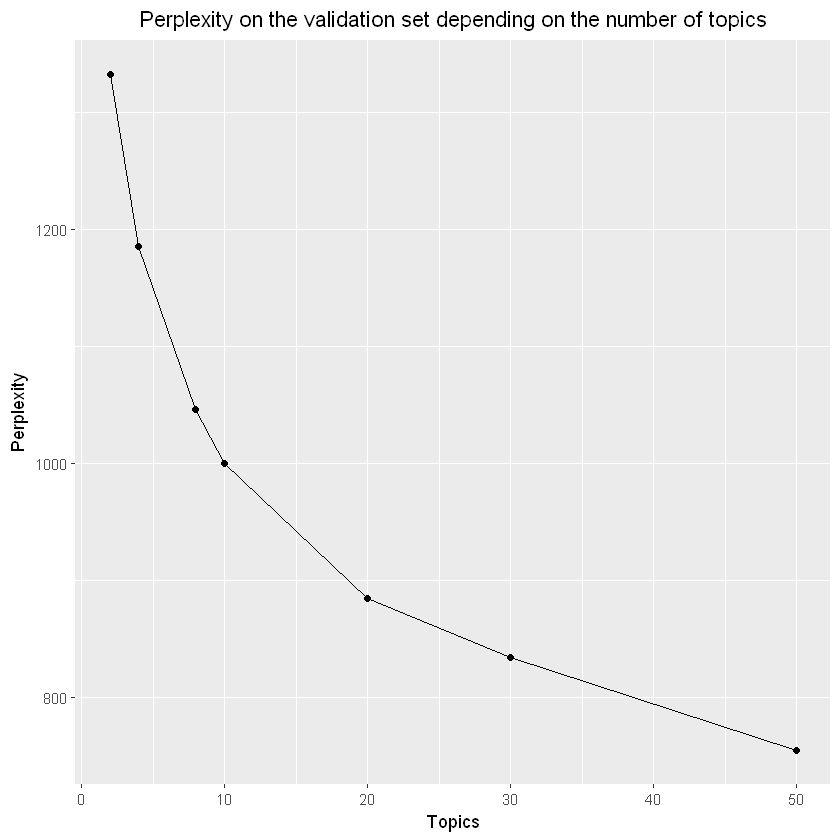

In [81]:
num_topics_vs_perplexity <- data.frame(Topics, Perplexity)
ggplot(num_topics_vs_perplexity, aes(Topics, Perplexity)) + 
    geom_line() + 
    geom_point() + 
    ggtitle("Perplexity on the validation set depending on the number of topics") +
    theme(plot.title = element_text(hjust = 0.5))

In [90]:
#Creating the document-term matrix priod to training LDA model with 30 topics
lda_document_matrix <- create_document_matrix(df)
lda_document_matrix

<<DocumentTermMatrix (documents: 2980, terms: 29146)>>
Non-/sparse entries: 592074/86263006
Sparsity           : 99%
Maximal term length: 74
Weighting          : term frequency (tf)

In [91]:
lda_model <- create_lda_model(lda_document_matrix, 30)
lda_model

A LDA_VEM topic model with 30 topics.

In [146]:
save(lda_model, file = "lda_model_30Topics.rda")
#load("lda_model_30Topics.rda")

In [158]:
#New features! Here we append the vector of gamma probabilities associated to each of the 30 topics to our patent metadata.
abstract_documents <- tidy(lda_model, matrix = "gamma")

In [159]:
documents_topics <- abstract_documents %>%
   group_by(document) %>%
   top_n(1, gamma) %>%
   ungroup()
topic_probabilities <- abstract_documents %>%
   mutate(topic = paste("topic", topic, sep="_")) %>%
   spread(key = topic, value = gamma) %>%
   left_join(documents_topics, by="document") 

In [160]:
patents <- df %>%
   mutate(document = as.character(unclass(PatentNo))) %>%
   left_join(topic_probabilities, by="document")
write_csv(patents, "PatentWithTopics.csv")

# Multi-label classification

In [22]:
# Set colour scheme
my_theme <- function(base_size = 10, base_family = "sans"){
  theme_minimal(base_size = base_size, base_family = base_family) +
    theme(
      axis.text = element_text(size = 10),
      axis.text.x = element_text(angle = 0, vjust = 0.5, hjust = 0.5),
      axis.title = element_text(size = 10),
      panel.grid.major = element_line(color = "gray"),
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "#f7fdff"),
      strip.background = element_rect(fill = "#001d60", color = "#00113a", size =0.5),
      strip.text = element_text(face = "bold", size = 10, color = "white"),
      legend.position = "bottom",
      legend.justification = "center",
      legend.background = element_blank(),
      panel.border = element_rect(color = "grey5", fill = NA, size = 0.5)
    )
}

theme_set(my_theme())

myfillcolors=c("#ff003f","#0094ff", "#ae00ff" , "#94ff00", "#ffc700","#fc1814")
mycolors=c("#db0229","#026bdb","#48039e","#0d7502","#c97c02","#c40c09")

In [2]:
patents <- read.csv("PatentWithTopics.csv", na.string="NA")
patents <- patents[, -c(1,12:296,323,354:355)]
# patents <- patents[, -c(1,12:323,354:355)]
# patents <- na.omit(patents)

In [3]:
#Convert target variables to logical. Necessary for mldr
patents$G05D <- as.logical(patents$G05D)
patents$B60W <- as.logical(patents$B60W)
patents$G01S <- as.logical(patents$G01S)
patents$G08G <- as.logical(patents$G08G)
patents$B62D <- as.logical(patents$B62D)
patents$G01C <- as.logical(patents$G01C)
patents$G06K <- as.logical(patents$G06K)
patents$B25J <- as.logical(patents$B25J)
patents$Y10S <- as.logical(patents$Y10S)
patents$G05B <- as.logical(patents$G05B)

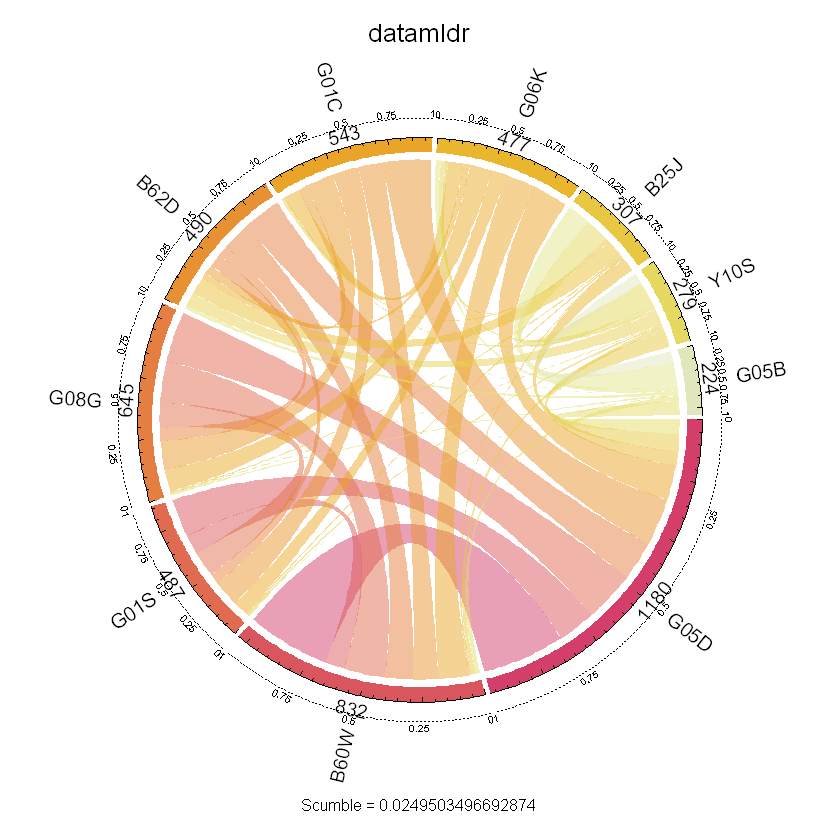

In [4]:
# Scumble plot allows us to see the co-occurence between labels:
datamldr=mldr_from_dataframe(patents,labelIndices=c(1:10))
plot(type="LC",datamldr, color.function = colorspace::heat_hcl)

In [5]:
#Create a task for mlr
labels=c("G05D","B60W","G01S","G08G","B62D", "G01C","G06K","B25J","Y10S","G05B")
multi.task = makeMultilabelTask(id = "multi", data=patents,target=labels)

In [6]:
folds.patents <- stratified.kfolds(datamldr)
train <- folds.patents[[1]]$train
test <- folds.patents[[1]]$test
train.set=row.names(train$dataset)%>%as.integer()
str(train.set)

 int [1:2385] 1 2 4 6 8 9 10 12 16 18 ...


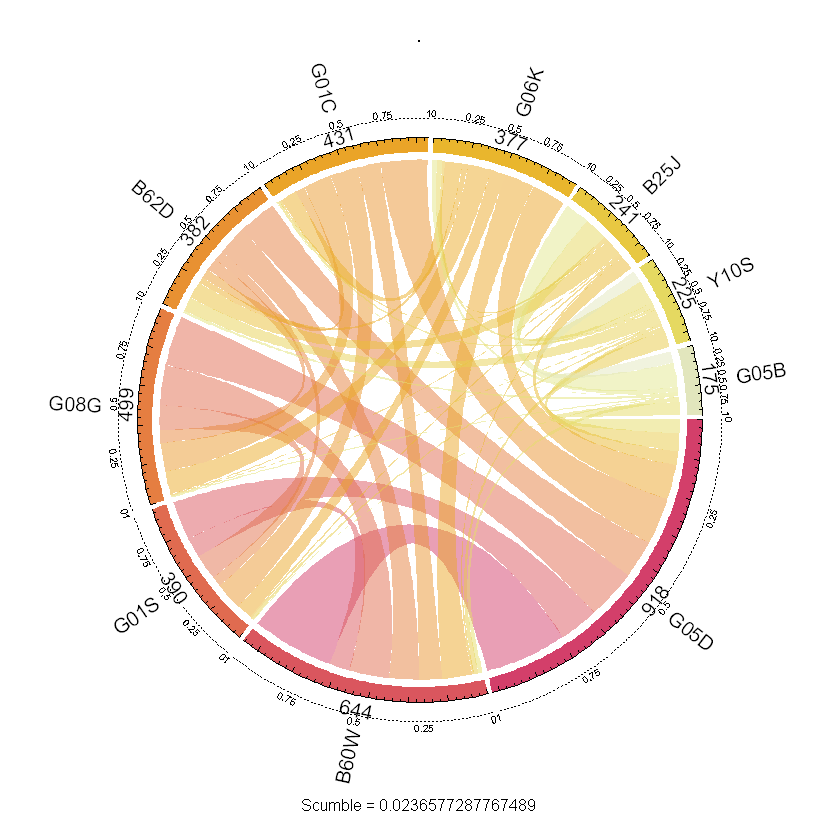

In [7]:
# Check that the train and test data samples are indeed stratified
train$dataset%>%mldr_from_dataframe(.,labelIndices=c(1:10))%>%plot(type="LC",., color.function = colorspace::heat_hcl)

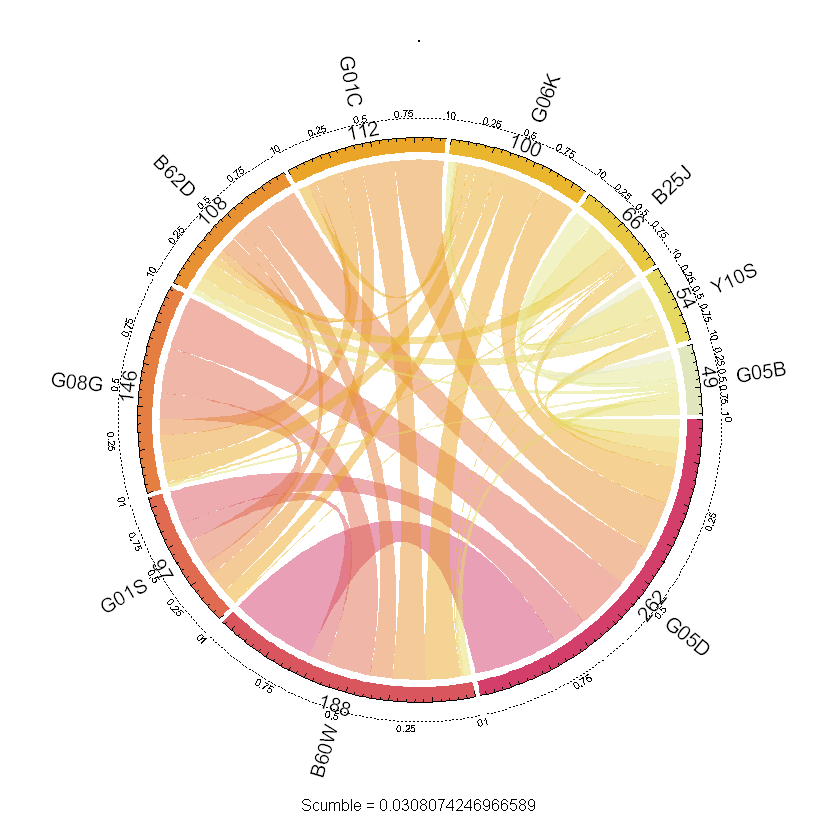

In [8]:
test$dataset%>%mldr_from_dataframe(.,labelIndices=c(1:10))%>%plot(type="LC",., color.function = colorspace::heat_hcl)

In [9]:
# Algorithm adaptation method
lrn.rfsrc = makeLearner("multilabel.randomForestSRC",predict.type = "prob")

In [40]:
# Problem transformation method
#Core learner
lrn.core= makeLearner("classif.boosting", predict.type = "prob")

In [41]:
#5 Wrapped learners
lrn.binrel=makeMultilabelBinaryRelevanceWrapper(lrn.core)
lrn.chain=makeMultilabelClassifierChainsWrapper(lrn.core)
lrn.nest=makeMultilabelNestedStackingWrapper(lrn.core)
lrn.dbr= makeMultilabelDBRWrapper(lrn.core)
lrn.stack=makeMultilabelStackingWrapper(lrn.core)

In [42]:
#Training 6 models on train subset
# mod.rf=train(lrn.rfsrc,multi.task,subset=train.set)
mod.binrel=mlr::train(lrn.binrel,multi.task,subset=train.set)
mod.chain=mlr::train(lrn.chain,multi.task,subset=train.set)
mod.nest=mlr::train(lrn.nest,multi.task,subset=train.set)
mod.dbr=mlr::train(lrn.dbr,multi.task,subset=train.set)
mod.stack=mlr::train(lrn.stack,multi.task,subset=train.set)

In [56]:
#Save models
# save(mod.rf, file = "rfsrcMod.rda")
save(mod.binrel, file = "mod.binrel.rda")
save(mod.chain, file = "mod.chain.rda")
save(mod.nest, file = "mod.nest.rda")
save(mod.dbr, file = "mod.dbr.rda")
save(mod.stack, file = "mod.stack.rda")
#load("lda_model_30Topics.rda")

In [49]:
#Predictions on test subset

# Uncomment if using time-based sampling
# pred.rf=predict(mod.rf,newdata=test)
# pred.binrel=predict(mod.binrel,newdata=test)
# pred.chain=predict(mod.chain,newdata=test)
# pred.nest=predict(mod.nest,newdata=test)
# pred.dbr=predict(mod.dbr,newdata=test)
# pred.stack=predict(mod.stack,newdata=test)

pred.rf=predict(mod.rf,newdata=test$dataset)
pred.binrel=predict(mod.binrel,newdata=test$dataset)
pred.chain=predict(mod.chain,newdata=test$dataset)
pred.nest=predict(mod.nest,newdata=test$dataset)
pred.dbr=predict(mod.dbr,newdata=test$dataset)
pred.stack=predict(mod.stack,newdata=test$dataset)

In [57]:
# Performance analysis

measures=list(multilabel.f1,multilabel.hamloss,multilabel.subset01,multilabel.ppv,multilabel.tpr)

p1=performance(pred.rf,measures)
p2=performance(pred.binrel,measures)
p3=performance(pred.chain,measures)
p4=performance(pred.nest,measures)
p5=performance(pred.dbr,measures)
p6=performance(pred.stack,measures)

performance=as.data.frame(rbind(p1,p2,p3,p4,p5,p6))
performance$model=c("RandomForest","Binaryrelevance","Chains","Nested","DBR","Stacking")

In [58]:
plong=gather(performance,metrics,value,multilabel.f1:multilabel.tpr, factor_key=TRUE)

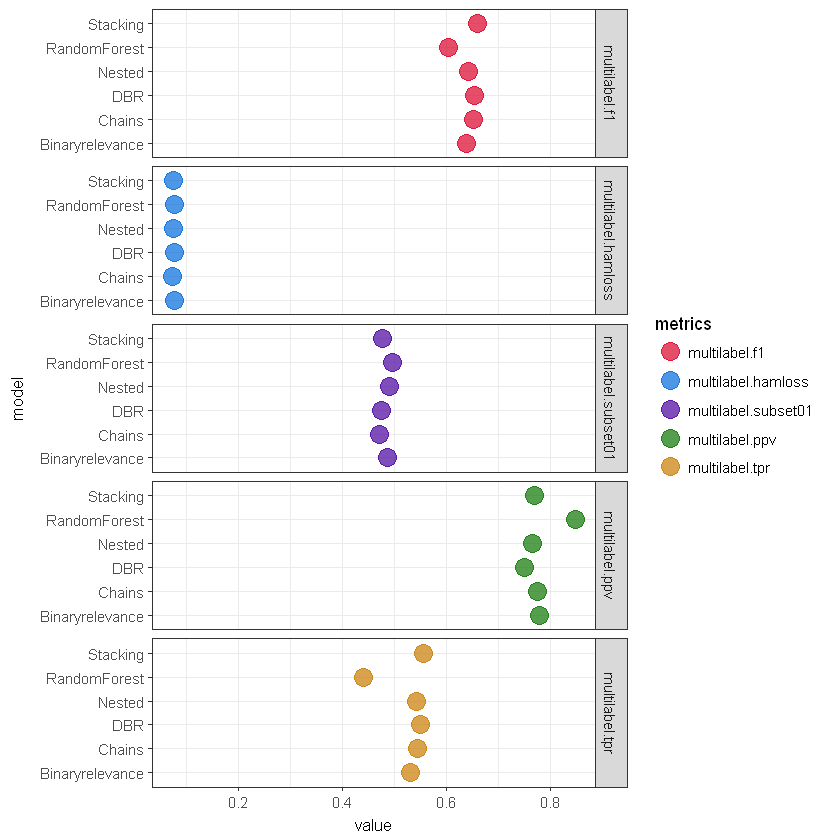

In [59]:
plong=gather(performance,metrics,value,multilabel.f1:multilabel.tpr, factor_key=TRUE)

ggplot(plong)+geom_point(aes(x=model,y=value,color=metrics),size=5,alpha=0.7)+facet_grid(metrics~.)+coord_flip()+theme_bw()+scale_color_manual(values=mycolors)

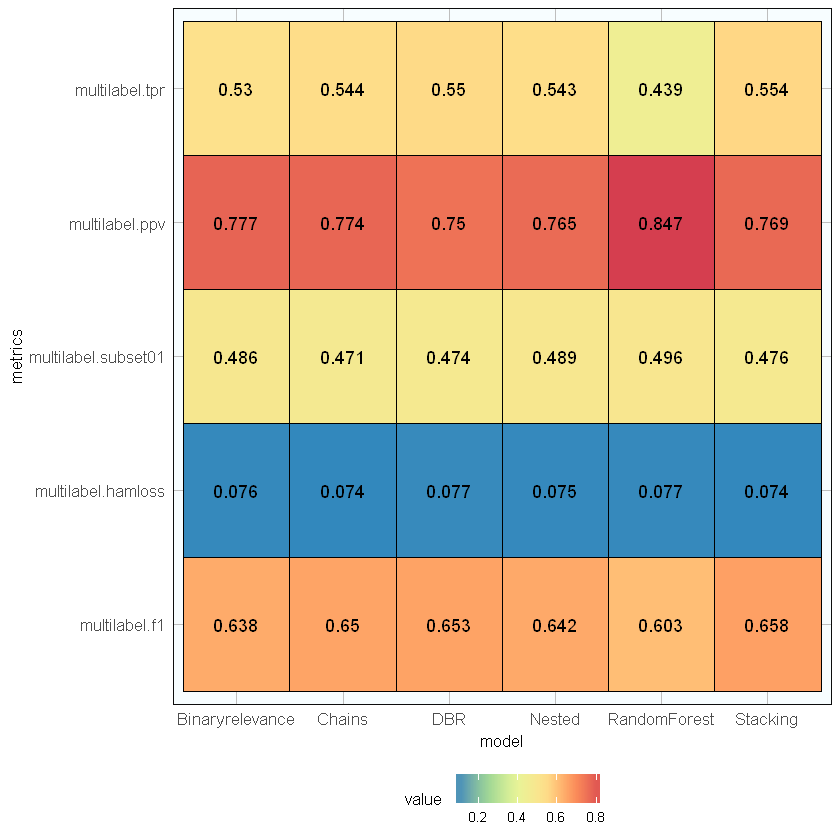

In [60]:
ggplot(plong)+geom_tile(aes(x=model,y=metrics,fill=value),color="black")+geom_text(aes(x=model,y=metrics,label=round(value,3)),color="black")+scale_fill_distiller(palette = "Spectral")

# Binary performance indicators

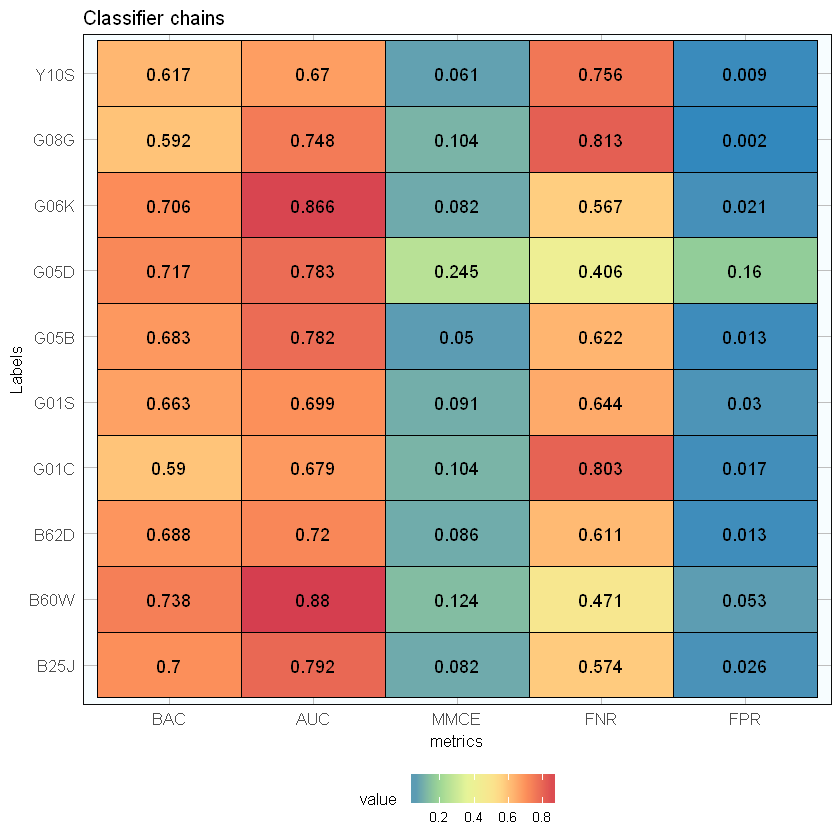

In [185]:
perbin.chain=getMultilabelBinaryPerformances(pred.chain,list(bac,auc,mmce,fnr,fpr))%>%as.data.frame()
perbin.chain$Labels=c("G05D", "B60W", "G01S", "G08G", "B62D", "G01C","G06K","B25J","Y10S","G05B")
perbin.chain=plyr::rename(perbin.chain, c("bac.test.mean"="BAC", "auc.test.mean"="AUC","mmce.test.mean"="MMCE","fnr.test.mean"="FNR","fpr.test.mean"="FPR"))
pblong=gather(perbin.chain,metrics,value,BAC:FPR, factor_key=TRUE)
ggplot(pblong)+geom_tile(aes(x=metrics,y=Labels,fill=value),color="black")+scale_fill_distiller(palette = "Spectral")+geom_text(aes(x=metrics,y=Labels,label=round(value,3)),color="black")+ggtitle("Classifier chains")

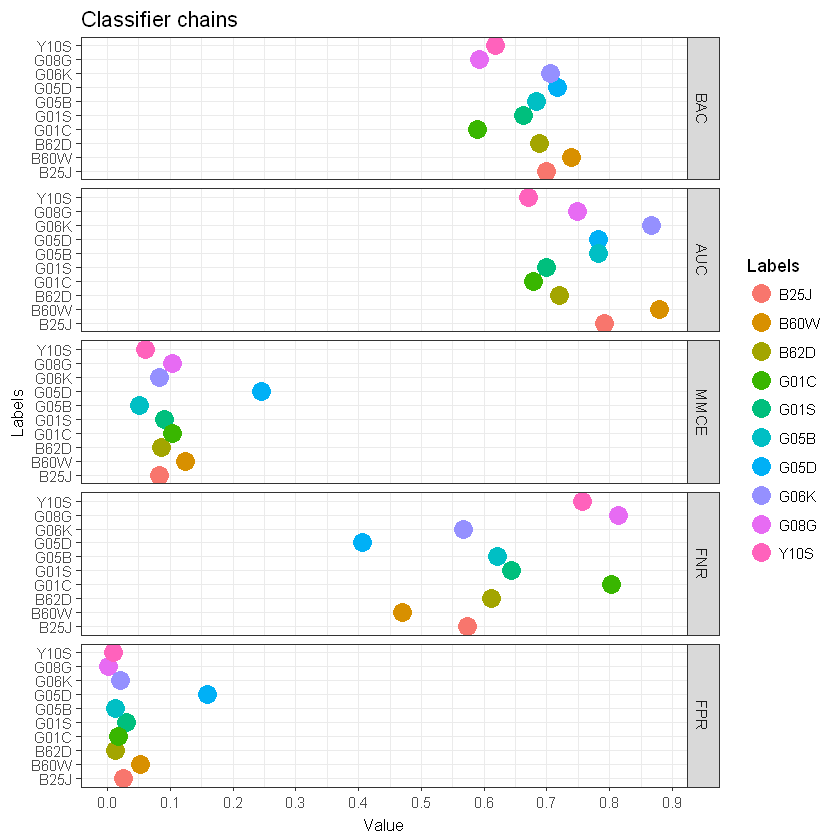

In [186]:
ggplot(pblong)+geom_point(aes(x=Labels,y=value,color=Labels),size=5)+scale_y_continuous("Value",breaks=c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))+coord_flip()+facet_grid(metrics~.)+theme_bw()+ggtitle("Classifier chains")

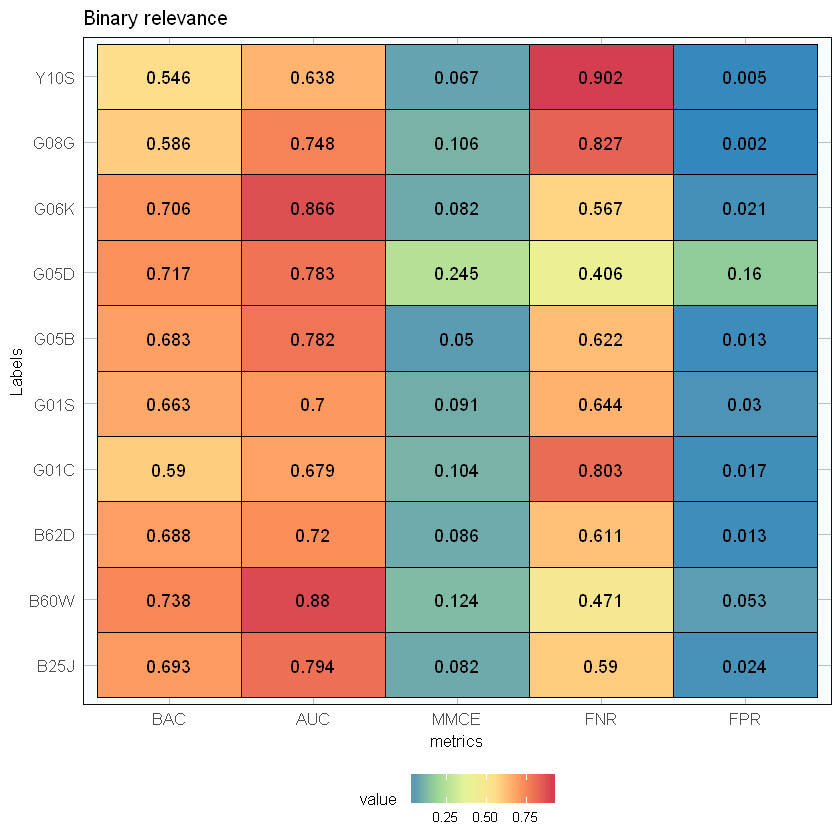

In [187]:
perbin.binrel=getMultilabelBinaryPerformances(pred.binrel,list(bac,auc,mmce,fnr,fpr))%>%as.data.frame()
perbin.binrel$Labels=c("G05D", "B60W", "G01S", "G08G", "B62D", "G01C","G06K","B25J","Y10S","G05B")
perbin.binrel=plyr::rename(perbin.binrel, c("bac.test.mean"="BAC", "auc.test.mean"="AUC","mmce.test.mean"="MMCE","fnr.test.mean"="FNR","fpr.test.mean"="FPR"))
pblong=gather(perbin.binrel,metrics,value,BAC:FPR, factor_key=TRUE)
ggplot(pblong)+geom_tile(aes(x=metrics,y=Labels,fill=value),color="black")+scale_fill_distiller(palette = "Spectral")+geom_text(aes(x=metrics,y=Labels,label=round(value,3)),color="black")+ggtitle("Binary relevance")

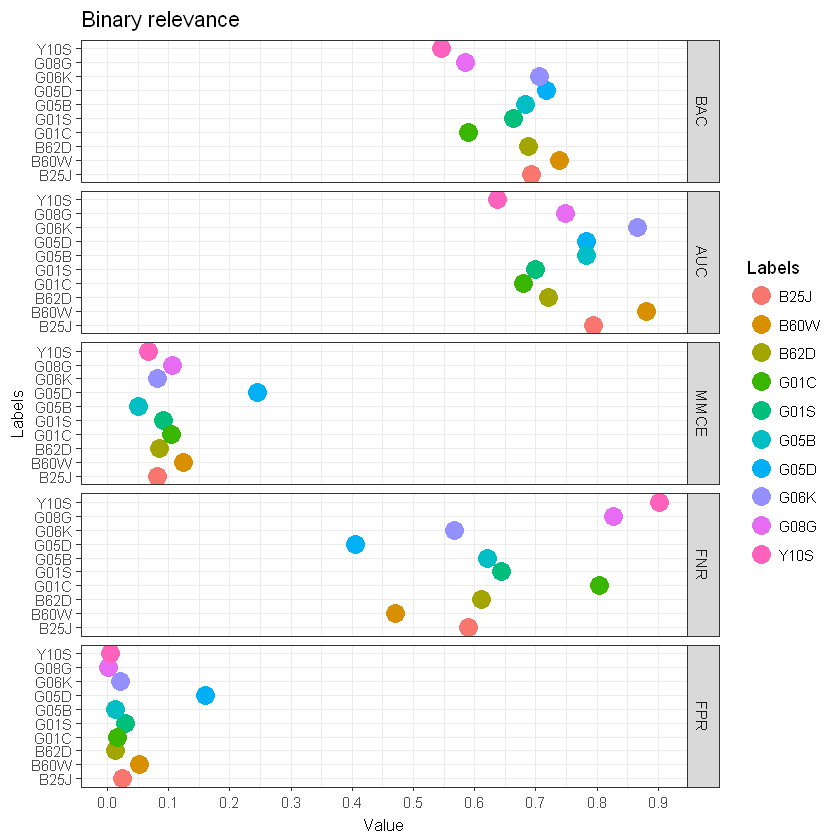

In [188]:
ggplot(pblong)+geom_point(aes(x=Labels,y=value,color=Labels),size=5)+scale_y_continuous("Value",breaks=c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))+coord_flip()+facet_grid(metrics~.)+theme_bw()+ggtitle("Binary relevance")

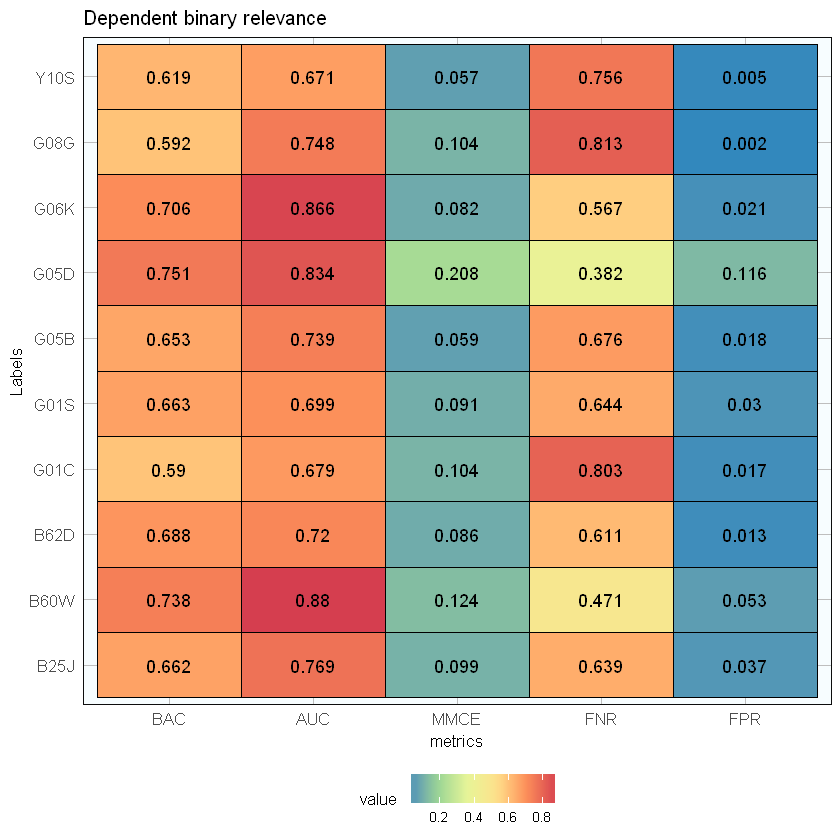

In [189]:
perbin.dbr=getMultilabelBinaryPerformances(pred.dbr,list(bac,auc,mmce,fnr,fpr))%>%as.data.frame()
perbin.dbr$Labels=c("G05D", "B60W", "G01S", "G08G", "B62D", "G01C","G06K","B25J","Y10S","G05B")
perbin.dbr=plyr::rename(perbin.dbr, c("bac.test.mean"="BAC", "auc.test.mean"="AUC","mmce.test.mean"="MMCE","fnr.test.mean"="FNR","fpr.test.mean"="FPR"))
pblong=gather(perbin.dbr,metrics,value,BAC:FPR, factor_key=TRUE)
ggplot(pblong)+geom_tile(aes(x=metrics,y=Labels,fill=value),color="black")+scale_fill_distiller(palette = "Spectral")+geom_text(aes(x=metrics,y=Labels,label=round(value,3)),color="black")+ggtitle("Dependent binary relevance")

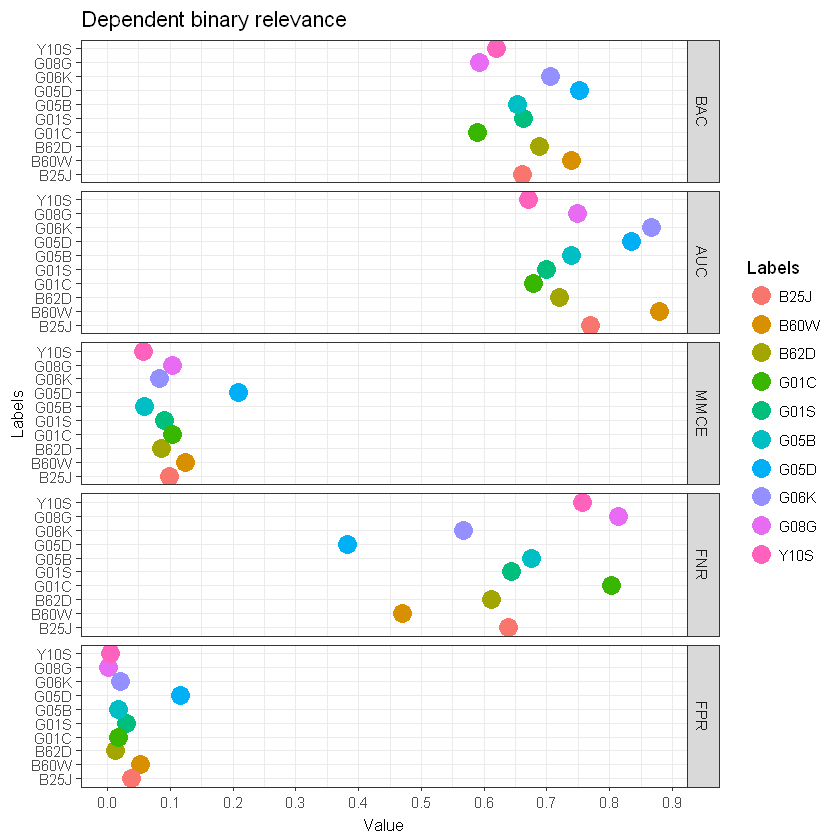

In [190]:
ggplot(pblong)+geom_point(aes(x=Labels,y=value,color=Labels),size=5)+scale_y_continuous("Value",breaks=c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))+coord_flip()+facet_grid(metrics~.)+theme_bw()+ggtitle("Dependent binary relevance")

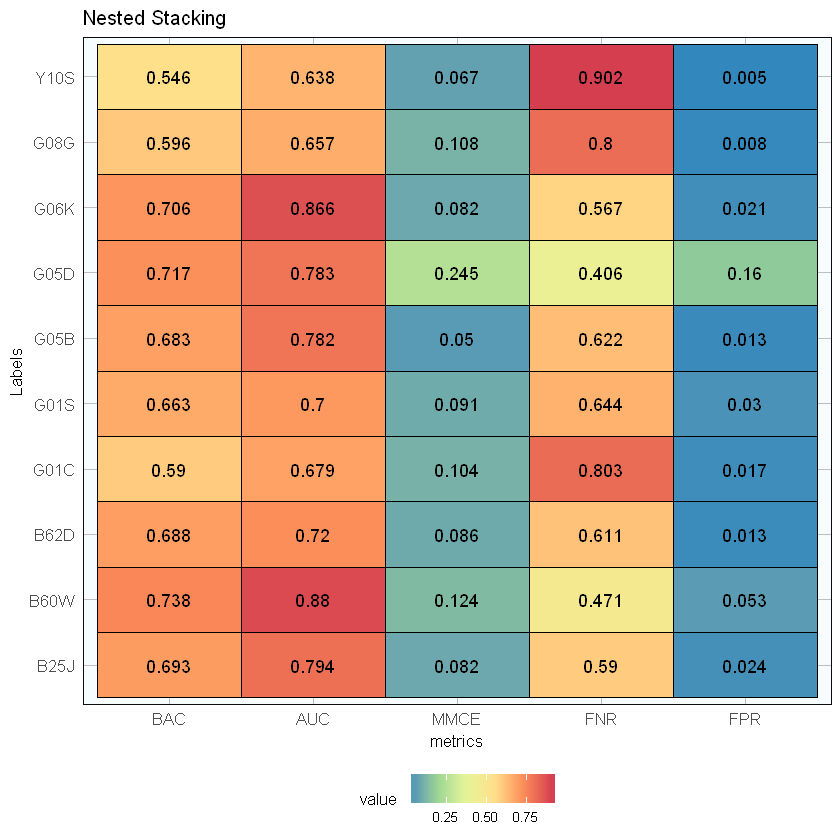

In [191]:
perbin.nest=getMultilabelBinaryPerformances(pred.nest,list(bac,auc,mmce,fnr,fpr))%>%as.data.frame()
perbin.nest$Labels=c("G05D", "B60W", "G01S", "G08G", "B62D", "G01C","G06K","B25J","Y10S","G05B")
perbin.nest=plyr::rename(perbin.nest, c("bac.test.mean"="BAC", "auc.test.mean"="AUC","mmce.test.mean"="MMCE","fnr.test.mean"="FNR","fpr.test.mean"="FPR"))
pblong=gather(perbin.nest,metrics,value,BAC:FPR, factor_key=TRUE)
ggplot(pblong)+geom_tile(aes(x=metrics,y=Labels,fill=value),color="black")+scale_fill_distiller(palette = "Spectral")+geom_text(aes(x=metrics,y=Labels,label=round(value,3)),color="black")+ggtitle("Nested Stacking")

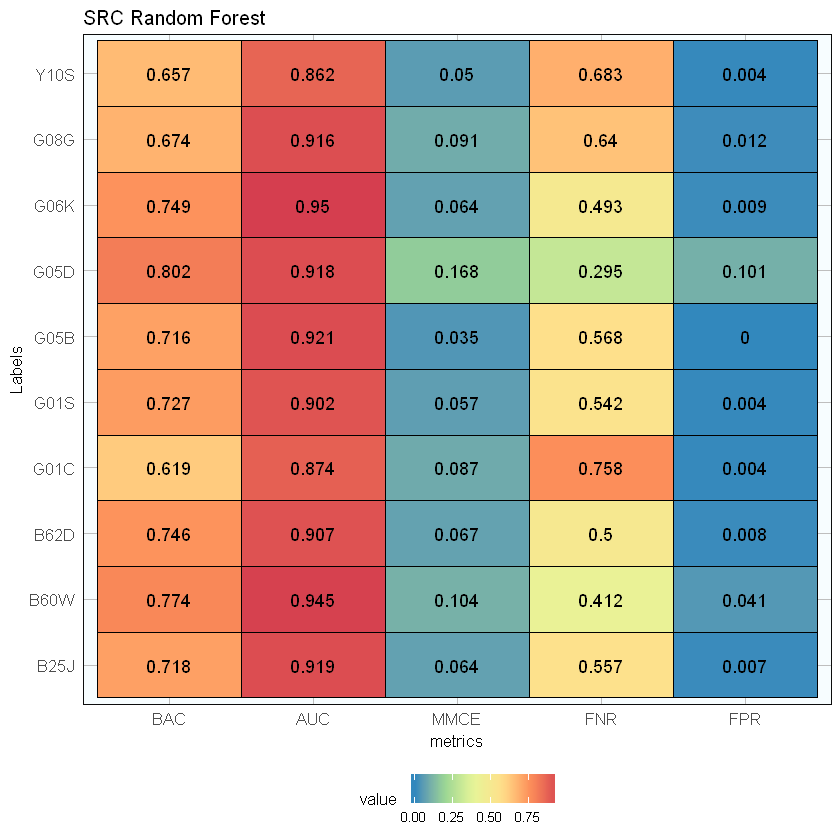

In [192]:
perbin.rf=getMultilabelBinaryPerformances(pred.rf,list(bac,auc,mmce,fnr,fpr))%>%as.data.frame()
perbin.rf$Labels=c("G05D", "B60W", "G01S", "G08G", "B62D", "G01C","G06K","B25J","Y10S","G05B")
perbin.rf=plyr::rename(perbin.rf, c("bac.test.mean"="BAC", "auc.test.mean"="AUC","mmce.test.mean"="MMCE","fnr.test.mean"="FNR","fpr.test.mean"="FPR"))
pblong=gather(perbin.rf,metrics,value,BAC:FPR, factor_key=TRUE)
ggplot(pblong)+geom_tile(aes(x=metrics,y=Labels,fill=value),color="black")+scale_fill_distiller(palette = "Spectral")+geom_text(aes(x=metrics,y=Labels,label=round(value,3)),color="black")+ggtitle("SRC Random Forest")

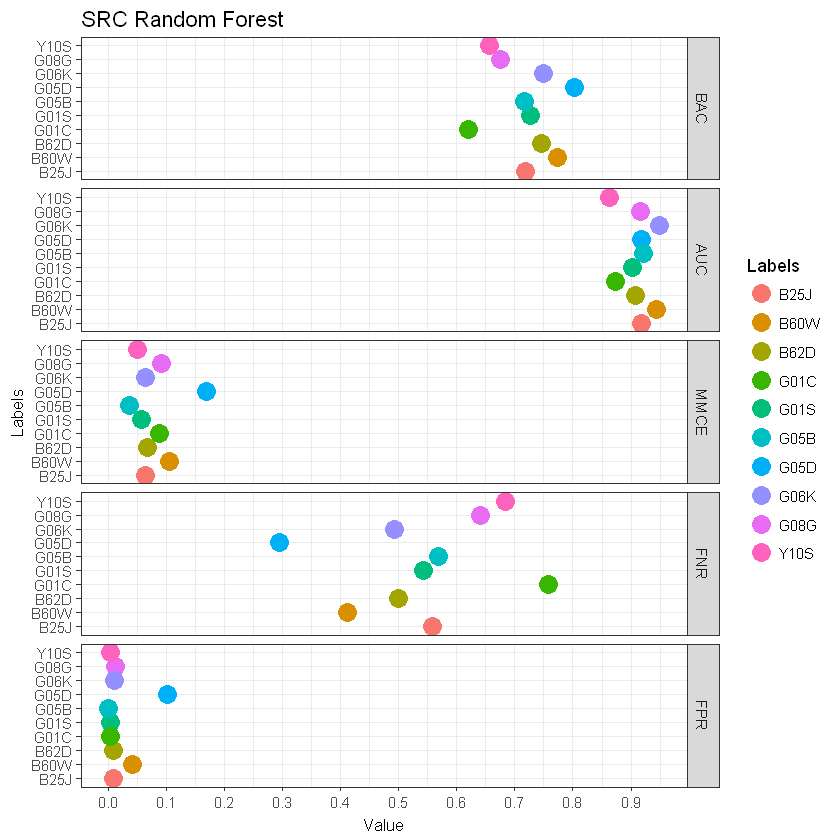

In [193]:
ggplot(pblong)+geom_point(aes(x=Labels,y=value,color=Labels),size=5)+scale_y_continuous("Value",breaks=c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))+coord_flip()+facet_grid(metrics~.)+theme_bw()+ggtitle("SRC Random Forest")

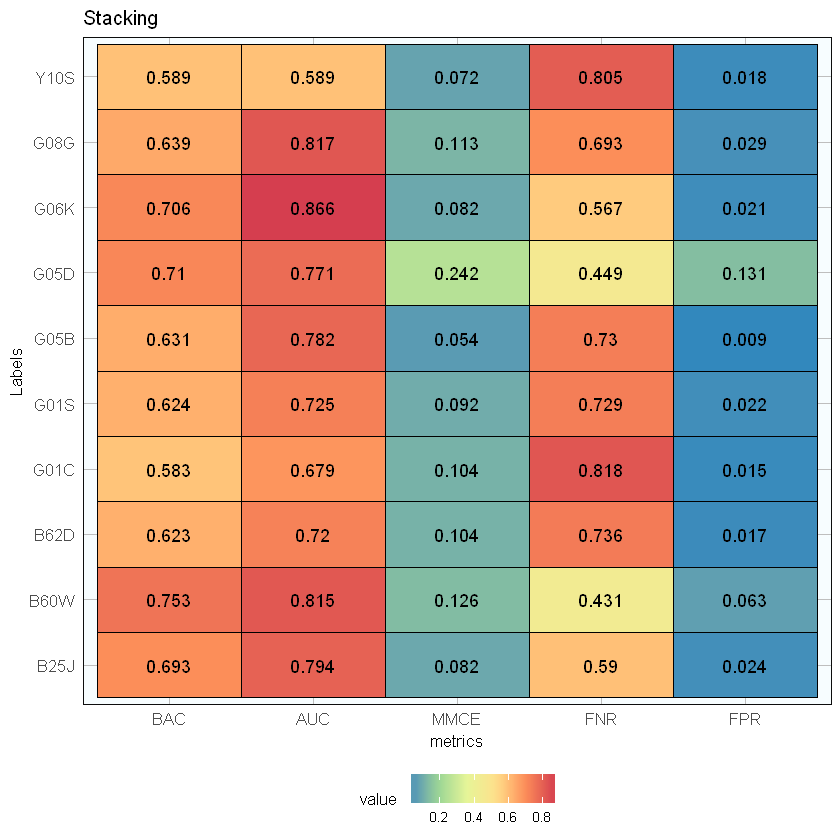

In [194]:
perbin.stack=getMultilabelBinaryPerformances(pred.stack,list(bac,auc,mmce,fnr,fpr))%>%as.data.frame()
perbin.stack$Labels=c("G05D", "B60W", "G01S", "G08G", "B62D", "G01C","G06K","B25J","Y10S","G05B")
perbin.stack=plyr::rename(perbin.stack, c("bac.test.mean"="BAC", "auc.test.mean"="AUC","mmce.test.mean"="MMCE","fnr.test.mean"="FNR","fpr.test.mean"="FPR"))
pblong=gather(perbin.stack,metrics,value,BAC:FPR, factor_key=TRUE)
ggplot(pblong)+geom_tile(aes(x=metrics,y=Labels,fill=value),color="black")+scale_fill_distiller(palette = "Spectral")+geom_text(aes(x=metrics,y=Labels,label=round(value,3)),color="black")+ggtitle("Stacking")

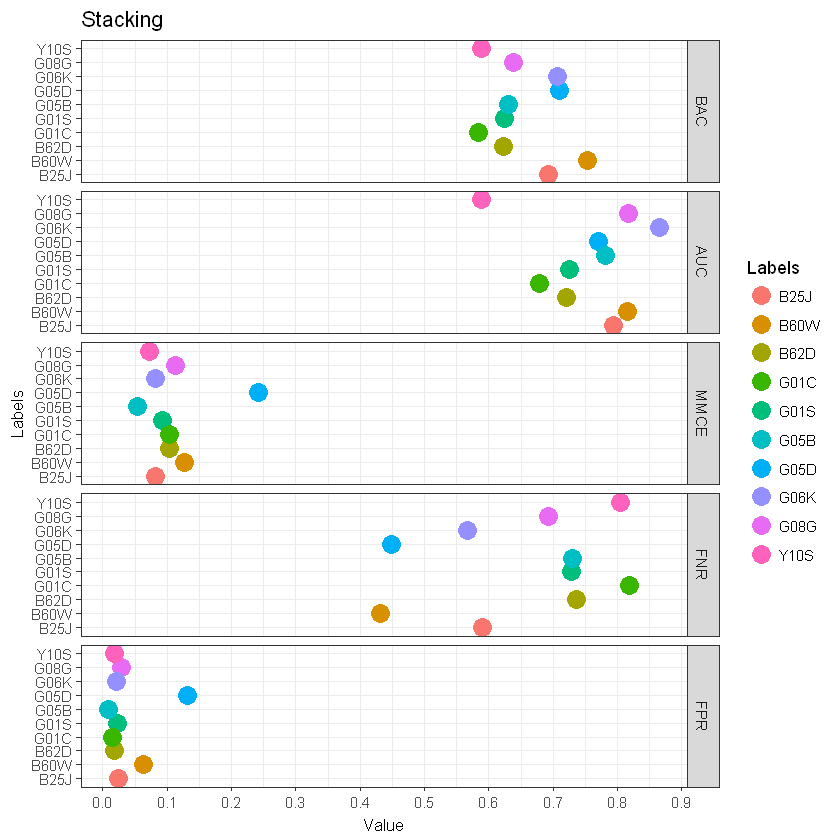

In [195]:
ggplot(pblong)+geom_point(aes(x=Labels,y=value,color=Labels),size=5)+scale_y_continuous("Value",breaks=c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))+coord_flip()+facet_grid(metrics~.)+theme_bw()+ggtitle("Stacking")

In [204]:
2*2

[1] 4